In [31]:
import torch
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from torch.utils.data import IterableDataset, DataLoader
from torchvision import transforms
import pathlib

import numpy as np
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
import logging
import random

# Set random seed
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)  # If using GPU
torch.cuda.manual_seed_all(seed)  # If using multiple GPUs
np.random.seed(seed)
random.seed(seed)

# Ensure deterministic behavior (reduce randomness)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Suppress unnecessary warnings
warnings.filterwarnings("ignore")

# Set logging level to show only ERROR level logs
logging.getLogger().setLevel(logging.ERROR)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Clear GPU memory (if previously occupied by other programs)
torch.cuda.empty_cache()

# Set PyTorch memory allocation strategy
torch.cuda.set_per_process_memory_fraction(0.8, device=0)  # Limit GPU memory usage to 80%

from ResEmoteNet.approach.ResEmoteNet import ResEmoteNet


Using device: cuda


In [32]:
data_folder = pathlib.Path('./dataset/')

### Split into Train, Validation, and Test

In [33]:
# Load test dataset
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    color_mode='grayscale',
    image_size=(64, 64),
    batch_size=16,
    shuffle=False,
    label_mode='categorical'
)

# Define PyTorch data preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Found 7178 files belonging to 7 classes.


### Convert the TensonFlow data folder to PyTorch formate

In [34]:
# Custom IterableDataset subclass
class TFDatasetToTorch(IterableDataset):
    def __init__(self, tf_dataset, transform):
        self.tf_dataset = tf_dataset
        self.transform = transform

    def __iter__(self):
        for images, labels in self.tf_dataset:
            images = images.numpy()
            labels = labels.numpy()
            for i in range(len(images)):
                img = images[i]
                img = self.transform(tf.keras.preprocessing.image.array_to_img(img))
                yield img, labels[i]

# Convert TensorFlow dataset to PyTorch DataLoader
def tf_to_torch(dataset, transform):
    torch_dataset = TFDatasetToTorch(dataset, transform)
    return DataLoader(torch_dataset, batch_size=16)

# Apply transformations
test_loader = tf_to_torch(test_dataset, transform)

# Retrieve class names
class_names = test_dataset.class_names
print("Class names:", class_names)

Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Normalization and Caching

In [35]:
# Assume class_names and device are already defined
# Create an instance of the model
model = ResEmoteNet()
model = model.to(device)

# Load pre-trained weights
model_path = "./models/best_model_fer2013_ResEmoteNet.pth"
checkpoint = torch.load(model_path, map_location=device)  # Load the weights file
# state_dict = checkpoint['model_state_dict']  # Extract model_state_dict
model.load_state_dict(checkpoint)  # Load the extracted state_dict
model.eval()
print("Model loaded successfully!")

Model loaded successfully!


Test Accuracy: 53.29%
Confusion Matrix:
 [[ 365    0   51  131  155  216   40]
 [  48    0    9   18   13   22    1]
 [ 121    0  149  115  190  297  152]
 [  58    0   19 1418  160   97   22]
 [  86    0   33  145  702  250   17]
 [ 135    0   57  116  309  601   29]
 [  20    0   51   66   68   36  590]]


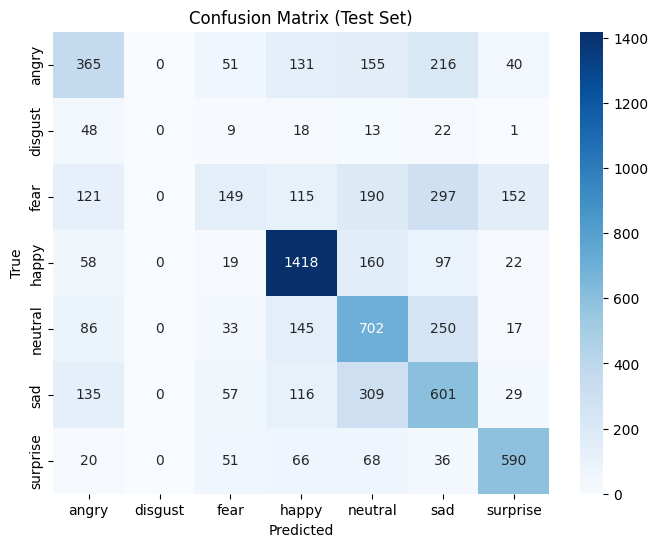

Classification Report:
               precision    recall  f1-score   support

       angry       0.44      0.38      0.41       958
     disgust       0.00      0.00      0.00       111
        fear       0.40      0.15      0.21      1024
       happy       0.71      0.80      0.75      1774
     neutral       0.44      0.57      0.50      1233
         sad       0.40      0.48      0.43      1247
    surprise       0.69      0.71      0.70       831

    accuracy                           0.53      7178
   macro avg       0.44      0.44      0.43      7178
weighted avg       0.52      0.53      0.51      7178



In [36]:
# Perform inference
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), torch.argmax(labels, dim=1).to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))